# Manipulating ADCP data from FORSA and M124 cruises

In [1]:
## Imports
import level1,level2,analysis,plottools,inversions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import datetime as dt
import scipy.stats as stats
import numpy.ma as ma
import scipy.optimize as optimization

## Open files

In [2]:
path1 = '/home/affholder/Documents/Stage/Araujo/Eddie_Tracks/FORSA_Data/FORSA_data/ADCP/'
path2 = '/home/affholder/Documents/ENS/AFC/Stage/Araujo/Eddie_Tracks/FORSA_Data/FORSA_data/ADCP/'
FORSA_path = path1
FORSA_filename = '151701.dat'
path3 = '/home/affholder/Documents/Stage/Araujo/Eddie_Tracks/M124_Data/ADCP/'
path4 = '/home/affholder/Documents/ENS/AFC/Stage/Araujo/Eddie_Tracks/M124_Data/ADCP/'
M124_path = path3
M124_filename = 'M124_ADCP_38khz.txt'

In [3]:
ADCP_F = level1.FORSA_translate(FORSA_path + FORSA_filename)
ADCP_M = level1.Meteor_translate(M124_path + M124_filename)

In [7]:
# np.save(FORSA_path + 'ADCP_FORSA.npy',ADCP_F)
# np.save(M124_path + 'ADCP_M38.npy',ADCP_M)

In [3]:
# Alternatively
# ADCP_F = np.load(FORSA_path + 'ADCP_FORSA.npy').item()
# ADCP_M = np.load(M124_path + 'ADCP_M38.npy').item()
# ADCP_F = np.load('../../ADCP_F.npy').item()
# ADCP_M = np.load('../../ADCP_M.npy').item()

In [4]:
# SSH data
SSH = nc.Dataset('../../SSHfields/global-analysis-forecast-phy-001-024_1522088461261.nc')

### Tracks of both campaigns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:4772: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:4773: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/basemap/__init__.py:4779: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
/usr/local/lib/python3.6/

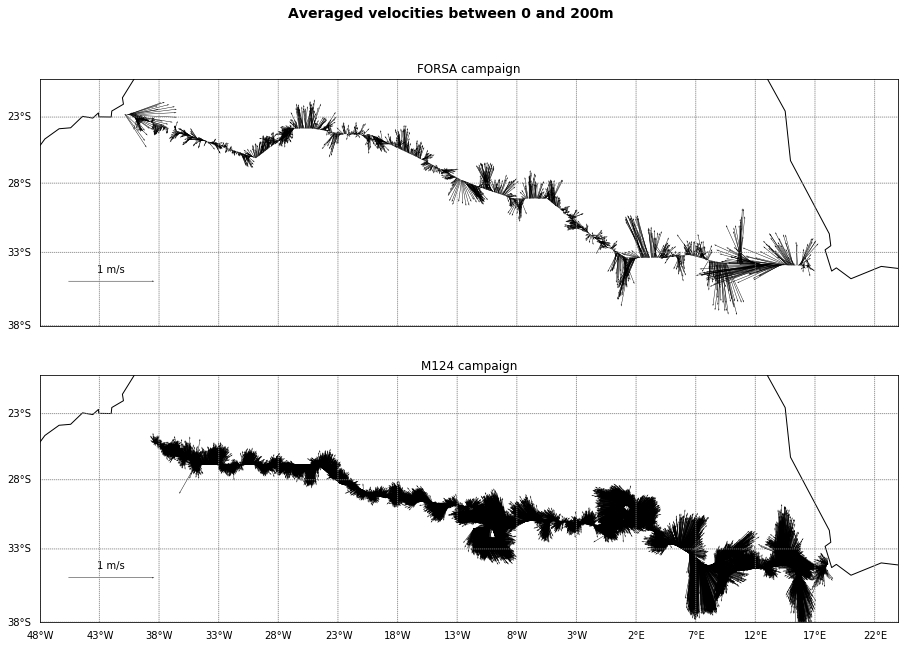

In [8]:
# Set up the figure
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
# Set up the limits and grid
lonmin = -48
lonmax = 24
latmin = -38
latmax = -20
grid = 5
maxdepth = 200
# Set up the projections
m1 = Basemap(ax=ax1,projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,llcrnrlon=lonmin,urcrnrlon=lonmax,resolution='c')
m2 = Basemap(ax=ax2,projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,llcrnrlon=lonmin,urcrnrlon=lonmax,resolution='c')
# Draw the map
m1.drawcoastlines()
m2.drawcoastlines()
# Draw parallels and meridians
parallels = np.arange(latmin,latmax,grid)
meridians = np.arange(lonmin,lonmax,grid)
m1.drawparallels(parallels,labels=[1,0,0,0],color='grey')
m1.drawmeridians(meridians,labels=[0,0,0,0],color='grey')
m2.drawparallels(parallels,labels=[1,0,0,0],color='grey')
m2.drawmeridians(meridians,labels=[0,0,0,1],color='grey')
# Plot the course and the currents
    # FORSA data
flon = ADCP_F['longitudes']
flat = ADCP_F['latitudes']
fU_m = np.nanmean(ADCP_F['U'][:,ADCP_F['depths'] < maxdepth],axis=1)
fV_m = np.nanmean(ADCP_F['V'][:,ADCP_F['depths'] < maxdepth],axis=1)
    # METEOR data
mlon = ADCP_M['longitudes']
mlat = ADCP_M['latitudes']
mU_m = np.nanmean(ADCP_M['U'][:,ADCP_M['depths'] < maxdepth],axis=1)
mV_m = np.nanmean(ADCP_M['V'][:,ADCP_M['depths'] < maxdepth],axis=1)
    # Plot everything
Qf = m1.quiver(flon,flat,fU_m,fV_m,latlon=True,scale=10,pivot='tail',width=0.0005)
Qm = m2.quiver(mlon,mlat,mU_m,mV_m,latlon=True,scale=10,pivot='tail',width=0.0005)
xleg = -42
yleg = -35
xlf,ylf = m1(xleg,yleg)
xlm,ylm = m2(xleg,yleg)
ax1.quiverkey(Qf,xlf,ylf,1, '1 m/s', coordinates='data')
ax2.quiverkey(Qm,xlm,ylm,1, '1 m/s', coordinates='data')

fig.suptitle('Averaged velocities between 0 and 200m', fontsize=14, fontweight='bold')
ax1.set_title('FORSA campaign')
ax2.set_title('M124 campaign')

plt.show()

## Extract data relative to eddies of interest

In [82]:
eddies = {'V1':{'ID':3697413,'box_X':[-0.5,5,5,-0.5,-0.5],'box_Y':[-35,-35,-30,-30,-35],'date':dt.datetime(2015,7,1)},
          'V3':{'ID':3699716,'box_X':[-14,-7.5,-7.5,-14,-14],'box_Y':[-31,-31,-26,-26,-31],'date':dt.datetime(2015,7,6)},
          'M10':{'ID':3810383,'box_X':[-12.5,-7.5,-7.5,-12.5,-12.5],'box_Y':[-34.5,-34.5,-29.5,-29.5,-34.5],'date':dt.datetime(2016,3,8)},
          'M12':{'ID':3812686,'box_X':[-29,-21.5,-21.,-29,-29],'box_Y':[-30,-30,-25,-25,-30],'date':dt.datetime(2016,3,13)}}
ADCP_M10 = level2.PolygonSubsetter(ADCP_M,eddies['M10']['box_X'],eddies['M10']['box_Y'])
ADCP_V1 = level2.PolygonSubsetter(ADCP_F,eddies['V1']['box_X'],eddies['V1']['box_Y'])
ADCP_M12 = level2.PolygonSubsetter(ADCP_M,eddies['M12']['box_X'],eddies['M12']['box_Y'])
ADCP_V3 = level2.PolygonSubsetter(ADCP_F,eddies['V3']['box_X'],eddies['V3']['box_Y'])
## Separate M10 in 2
lon = ADCP_M10['longitudes']
lat = ADCP_M10['latitudes']
V = ADCP_M10['V']
U = ADCP_M10['U']
depths = ADCP_M10['depths']
index_max_EW = np.where(lon == np.min(lon[:2000]))[0][0]
lon_EW = lon[:index_max_EW]
lat_EW = lat[:index_max_EW]
dates_EW = ADCP_M10['dates'][:index_max_EW]
direct_EW = ADCP_M10['directions'][:index_max_EW,:]
veloc_EW = ADCP_M10['velocities'][:index_max_EW,:]
U_EW = U[:index_max_EW,:]
V_EW = V[:index_max_EW,:]
index_min_SN = np.where(lat == np.min(lat))[0][0]
end = 2850
## Remove points where the ship was stopped
atd = analysis.ComputeATD(lon_EW,lat_EW)
datd = atd[1:] - atd[:-1]
delt = np.array([(dates_EW[i] - dates_EW[i-1]).total_seconds() for i in range(1,len(dates_EW))])
vit = datd/delt
keep = np.where(vit > 4)[0]
lon_EW = lon_EW[keep]
lat_EW = lat_EW[keep]
dates_EW = dates_EW[keep]
direct_EW = direct_EW[keep,:]
veloc_EW = veloc_EW[keep,:]
U_EW = U_EW[keep,:]
V_EW = V_EW[keep,:]


## Same thing for M12
lon12 = ADCP_M12['longitudes']
lat12 = ADCP_M12['latitudes']
atd12 = analysis.ComputeATD(lon12,lat12)
datd12 = atd12[1:] - atd12[:-1]
dates12 = ADCP_M12['dates']
delt12 = np.array([(dates12[i] - dates12[i-1]).total_seconds() for i in range(1,len(dates12))])
vit12 = datd12/delt12
keep12 = np.where(vit12 > 4)[0]
ADCP_M12['longitudes'] = lon12[keep12]
ADCP_M12['latitudes'] = lat12[keep12]
ADCP_M12['dates'] = dates12[keep12]
ADCP_M12['velocities'] = ADCP_M12['velocities'][keep12,:]
ADCP_M12['directions'] = ADCP_M12['directions'][keep,:]
ADCP_M12['U'] = ADCP_M12['U'][keep12,:]
ADCP_M12['V'] = ADCP_M12['V'][keep12,:]


lat_SN = lat[index_min_SN:end]
lon_SN = lon[index_min_SN:end]
dates_SN = ADCP_M10['dates'][:index_min_SN]
direct_SN = ADCP_M10['directions'][:index_min_SN,:]
veloc_SN = ADCP_M10['velocities'][:index_min_SN,:]
U_SN = U[index_min_SN:end,:]
V_SN = V[index_min_SN:end,:]
ADCP_M10_EW = {'depths':depths,'longitudes':lon_EW,'latitudes':lat_EW,'dates':dates_EW,
               'U':U_EW,'V':V_EW,'directions':direct_EW,'velocities':veloc_EW}
ADCP_M10_SN = {'depths':depths,'longitudes':lon_SN,'latitudes':lat_SN,'dates':dates_SN,
               'U':U_SN,'V':V_SN,'directions':direct_SN,'velocities':veloc_SN}
ADCPs = {'V1':ADCP_V1,'V3':ADCP_V3,
         'M10_EW':ADCP_M10_EW,'M10_SN':ADCP_M10_SN,'M10':ADCP_M10,'M12':ADCP_M12}

In [83]:
np.save('ADCPS',ADCPs)

## Adapt the coordinates

Here we add a coordinate system in meters to the matrixes enabling proper plotting of raw data which is the along-track distance

First, for the eddy extracted from the FORSA dataset, where horizontal resolution is around 4km and vertical resolution around 16m (goes to 700m).  
Here, the data is put on a regular grid for more accurate viewing. The resolution of the regular grid is still 4km but regular. 

A boxcar filter of dimensions (10km,130m) is applied to extract the mesoscale

In [84]:
ADCPs = {'V1':ADCP_V1,'V3':ADCP_V3,'M10':ADCP_M10_EW,'M12':ADCP_M12}
edkeys = list(eddies.keys())
for i in range(len(ADCPs)):
    edkey = edkeys[i]
    ADCP = ADCPs[edkey]
    if edkey == 'V1' or edkey == 'V3':
        xbins = 5
        ybins = 3
        xreg = 4000
    if edkey == 'M10' or edkey == 'M12':
        xbins = 50
        ybins = 2
        xreg = 400
    lon = ADCP['longitudes']
    lat = ADCP['latitudes']
    depths = ADCP['depths']
    V = ADCP['V']
    U = ADCP['U']
    atd = analysis.ComputeATD(lon,lat)                        # Compute the ATD 
    V_reg,atd_reg = analysis.RegularGrid(V,atd,xreg,depths)   # Put the data on a regular grid
    V_reg_filt = analysis.BoxCarFilter(V_reg,xbins,ybins)     # Apply a boxcar filter to the data
    U_reg,atd_reg2 = analysis.RegularGrid(U,atd,xreg,depths)   # Put the data on a regular grid
    U_reg_filt = analysis.BoxCarFilter(U_reg,xbins,ybins)
    ssh = analysis.TrackSSH(lon,lat,SSH,eddies[edkey]['date'])# Extract SSH
    eddies[edkey]['longitudes'] = lon
    eddies[edkey]['latitudes'] = lat
    eddies[edkey]['depths'] = depths
    eddies[edkey]['ATD'] = atd
    eddies[edkey]['ATD reg'] = atd_reg
    eddies[edkey]['V'] = V
    eddies[edkey]['V reg'] = V_reg
    eddies[edkey]['V reg filt'] = V_reg_filt
    eddies[edkey]['U'] = U
    eddies[edkey]['U reg'] = U_reg
    eddies[edkey]['U reg filt'] = U_reg_filt
    eddies[edkey]['SSH'] = ssh

In [85]:
np.save('eddies_last',eddies)

In [12]:
eddies = np.load('../../eddies_last.npy').item()

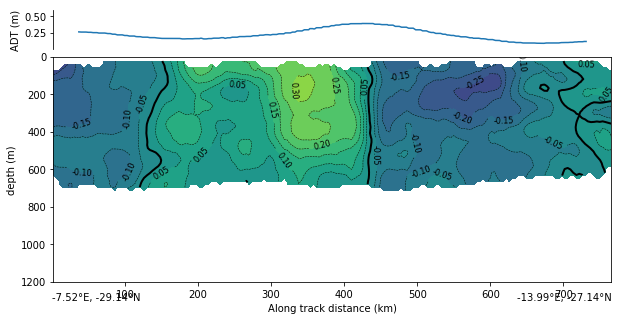

In [25]:
eddy = 'V3'
lon = eddies[eddy]['longitudes']
lat = eddies[eddy]['latitudes']
depths = eddies[eddy]['depths']
atd_reg = eddies[eddy]['ATD reg']
atd = eddies[eddy]['ATD']
V_reg_filt = eddies[eddy]['V reg filt']
ssh = eddies[eddy]['SSH']

fig = plt.figure(figsize=(10,5))
ax2 = plt.subplot2grid((6, 1), (0, 0))
ax1 = plt.subplot2grid((6, 1), (1, 0), rowspan=5)
ax1.set_ylim(1200,0)

plottools.PlotADCP(ax1,atd_reg/1000,depths,V_reg_filt)
# Plot SSH
ax2.plot(atd/1000,ssh)
ax2.spines['bottom'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.yaxis.set_ticks([.25,.5])
ax2.set_ylim(0,0.6)
ax2.xaxis.set_ticks([])
ax2.set_ylabel('ADT (m)')
ax1.set_ylabel('depth (m)')
ax1.set_xlabel('Along track distance (km)')

ax1.text(0,1280,str(np.round(lon[0],2)) + '°E, ' + str(np.round(lat[0],2)) + '°N',horizontalalignment='left',verticalalignment='center')
ax1.text(max(atd_reg/1000),1280,str(np.round(lon[-1],2)) + '°E, ' + str(np.round(lat[-1],2)) + '°N',horizontalalignment='right',verticalalignment='center')

plt.savefig('V3_atd.pdf')
plt.show()

Now for the Meteor dataset, the resolution is 32m depth until 1200m and 400m horizontal

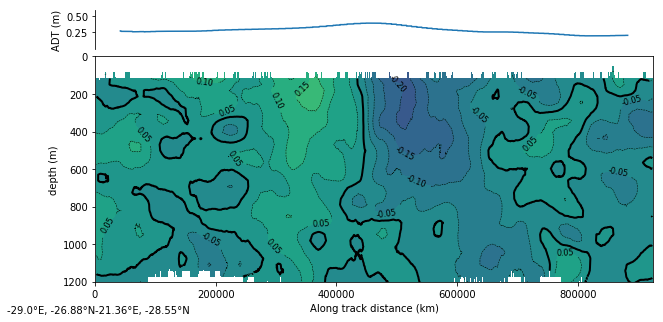

In [81]:
eddy = 'M12'
lon = eddies[eddy]['longitudes']
lat = eddies[eddy]['latitudes']
depths = eddies[eddy]['depths']
atd_reg = eddies[eddy]['ATD reg']
atd = eddies[eddy]['ATD']
V_reg_filt = eddies[eddy]['V reg filt']
ssh = eddies[eddy]['SSH']
# Figure
fig = plt.figure(figsize=(10,5))
ax2 = plt.subplot2grid((6, 1), (0, 0))
ax1 = plt.subplot2grid((6, 1), (1, 0), rowspan=5)
ax1.set_ylim(1200,0)

lvls = np.arange(-0.3,0.3,0.1)
plottools.PlotADCP(ax1,atd_reg,depths,V_reg_filt)
#plottools.PlotMaxMin(ax1,V_reg_filt,atd_reg,depths)
# Plot SSH
ax2.plot(atd/100,ssh)
ax2.spines['bottom'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.yaxis.set_ticks([.25,.5])
ax2.xaxis.set_ticks([])
ax2.set_ylim(0,0.6)
ax2.set_ylabel('ADT (m)')
ax1.set_ylabel('depth (m)')
ax1.set_xlabel('Along track distance (km)')

ax1.text(0,1350,str(np.round(lon[0],2)) + '°E, ' + str(np.round(lat[0],2)) + '°N',horizontalalignment='left',verticalalignment='center')
ax1.text(max(atd_reg/1000),1350,str(np.round(lon[-1],2)) + '°E, ' + str(np.round(lat[-1],2)) + '°N',horizontalalignment='right',verticalalignment='center')

#plt.savefig('M12_atd.pdf')
plt.show()

M10 SN section

In [68]:
atd = analysis.ComputeATD(lon_SN,lat_SN)
U_reg,atd_reg = analysis.RegularGrid(U_SN,atd,400,depths)
U_reg_filt = analysis.BoxCarFilter(U_reg,50,2)
ssh = analysis.TrackSSH(lon_SN,lat_SN,SSH,eddies['M10']['date'])

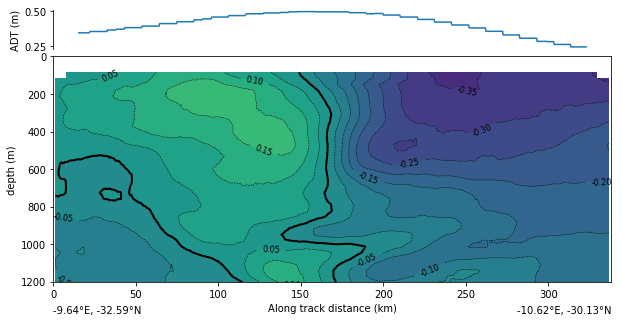

In [69]:
# Figure
fig = plt.figure(figsize=(10,5))
ax2 = plt.subplot2grid((6, 1), (0, 0))
ax1 = plt.subplot2grid((6, 1), (1, 0), rowspan=5)
ax1.set_ylim(1200,0)

lvls = np.arange(-0.3,0.3,0.1)
plottools.PlotADCP(ax1,atd_reg,depths,U_reg_filt)
#plottools.PlotMaxMin(ax1,V_reg_filt,atd_reg,depths)
# Plot SSH
ax2.plot(atd/100,ssh)
ax2.spines['bottom'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.yaxis.set_ticks([.25,.5])
ax2.xaxis.set_ticks([])
ax2.set_ylabel('ADT (m)')
ax1.set_ylabel('depth (m)')
ax1.set_xlabel('Along track distance (km)')

ax1.text(0,1350,str(np.round(lon_SN[0],2)) + '°E, ' + str(np.round(lat_SN[0],2)) + '°N',horizontalalignment='left',verticalalignment='center')
ax1.text(max(atd_reg/1000),1350,str(np.round(lon_SN[-1],2)) + '°E, ' + str(np.round(lat_SN[-1],2)) + '°N',horizontalalignment='right',verticalalignment='center')

#plt.savefig('M10_SN_atd.pdf')
plt.show()

### Find the eddie's virtual center : Hodographs

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


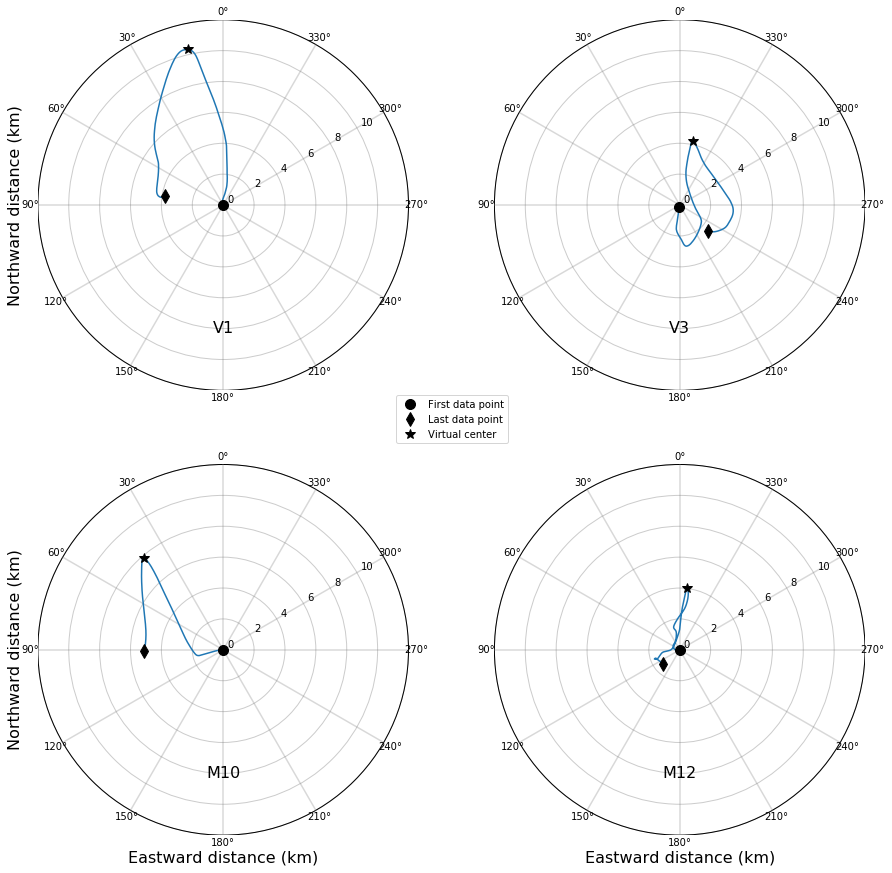

In [12]:
fig = plt.figure(figsize=(15,15))
edkeys = list(ADCPs.keys())
xtext = [False,False,True,True]
ytext = [True,False,True,False]
legend = [False,False,False,False]
for i in range(len(edkeys)):
    ADCP = ADCPs[edkeys[i]]
#     U = np.nanmean(ADCP['U'][:,ADCP['depths']<350],axis=1)
#     V = np.nanmean(ADCP['V'][:,ADCP['depths']<700],axis=1)
#     U = ADCP['U'][:,10]
#     V = ADCP['V'][:,10]
    U = np.nanmean(eddies[edkeys[i]]['U reg filt'][:,ADCP['depths']<350],axis=1)
    V = np.nanmean(eddies[edkeys[i]]['V reg filt'][:,ADCP['depths']<350],axis=1)
    lon = ADCP['longitudes']
    lat = ADCP['latitudes']
    deltat = np.round(np.mean(ADCP['dates'][1:] - ADCP['dates'][:-1]).total_seconds(),0)
    ax = fig.add_subplot(2,2,i+1)
    xlim = 12
    plottools.Hodograph(ax,xlim,xtext=xtext[i],ytext=ytext[i])
    plottools.PlotHodograph(ax,U,V,deltat,legend=legend[i])
    ax.text(0,-xlim+4,edkeys[i],fontsize=16,horizontalalignment='center',verticalalignment='center')
h,l=ax.get_legend_handles_labels()
ax.legend(handles=h,labels=l,bbox_to_anchor=(0.05,1.2))
#plt.savefig('hodographs.pdf')
plt.show()
    

We can now draw eddies with their virtual center

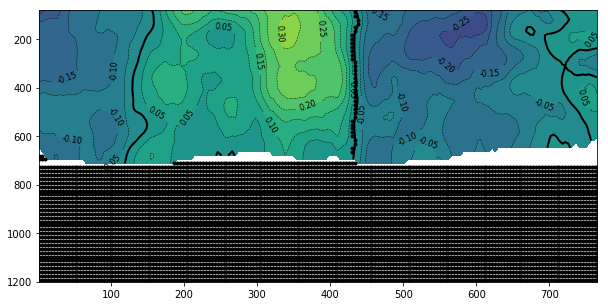

In [295]:
ADCP = ADCP_V3
eddy = 'V3'
atd = eddies[eddy]['ATD']
atd_reg = eddies[eddy]['ATD reg']
U = eddies[eddy]['U']
V = eddies[eddy]['V']
U_reg_filt = eddies[eddy]['U reg filt']
V_reg_filt = eddies[eddy]['V reg filt']
V_reg = eddies[eddy]['V reg']
U_reg = eddies[eddy]['U reg']
depths = eddies[eddy]['depths']
deltat = np.round(np.mean(ADCP['dates'][1:] - ADCP['dates'][:-1]).total_seconds(),0)
U_int = (np.nancumsum(U_reg_filt,axis=0)*deltat)/1000
V_int = (np.nancumsum(V_reg_filt,axis=0)*deltat)/1000
vintmax = np.nanmax(V_int,axis=0)
indexes = []
for i in range(len(depths)):
    v_int = V_int[:,i]
    index = np.where(v_int == vintmax[i])[0]
    indexes.append(index)
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(1200,80)
plottools.PlotADCP(ax,atd_reg,depths,V_reg_filt)
for i in range(len(indexes)):
    idxs = indexes[i]
    dpths = [depths[i]]*len(idxs)
    atds = atd_reg[idxs]
    ax.plot(atds/1000,dpths,'k.')

In [298]:
atd_reg[indexes[41]]

array([2000., 6000.])

In [299]:
depths[41]

680.0

#### Attempt to compute radial vorticity

In [18]:
V2 = V_reg_filt[:,:42]
depths2 = depths[:42]
indexes2 = indexes[:42]

In [19]:
zetas = []
for i in range(len(depths2)):
    new_atd = atd_reg - atd_reg[indexes2[i]]
    v = V2[:,i]
    b = v/new_atd
    zeta = 2*np.arctan(b)
    zetas.append(zeta)
zetas = np.array(zetas)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


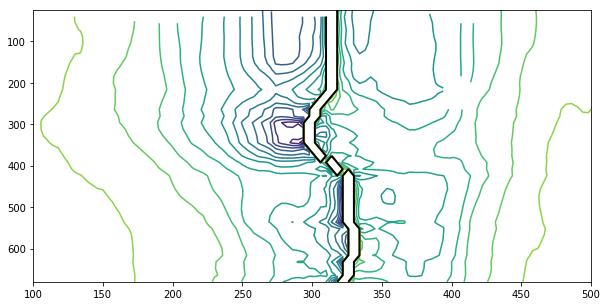

In [21]:
plt.figure(figsize=(10,5))
X,Y = np.meshgrid(atd_reg/1000,depths2)
levels = np.arange(-3e-5,5e-6,2e-6)
plt.xlim(100,500)
plt.contour(X,Y,zetas,levels=levels)
lvl0 = [0]
plt.contour(X,Y,zetas,levels=lvl0,colors='black',linewidths=2)
plt.gca().invert_yaxis()

As constated, the computation of radial vorticity poses some problems approaching the virtual center because it is not the real center, the velocities measured near the virtual center are much higher than the velocities that would be measured this close to the real center. Also, that makes the different eddies difficult to compare one another because the ships track are in different locations in the eddy frame

#### Find the real center and a method to compare different datasets

Here, we propose a method to find where the real center is by solving an inverse problem (minimizing angular distance between simulated data and measured data)

#### Simulate solid body rotation
$$
\begin{array}{r c l}
|U| & = & r \times \tan \omega \\
\alpha & = & \tan_2^{-1} \left (x,y)
\end{array}
$$

In [ ]:
# np.angle(u+v*1j,deg=True)


In [5]:
# I = [xcenter,ycenter,omega]
def Cost(I,um,vm,xm,ym):
    """
    um vm same length are data
    """
    N = len(um)
    xc = I[0]
    yc = I[1]
    o = I[2]
    us,vs = inversions.Simulate(xc,yc,xm,ym,omega=o)
    angles = np.arccos((um * us + vm * vs)/(np.sqrt(um**2 + vm**2) * np.sqrt(us**2 + vs**2)))
    N = np.sum(np.isfinite(angles))
    cost = np.nansum(angles)/N**2
    #rms = np.nansum(np.sqrt((um - us)**2 + (vm - vs)**2))/(np.sqrt(2*N))
    
    return(cost)

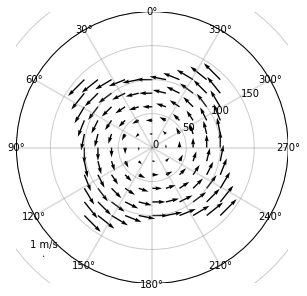

In [7]:
#simulate a whole eddy
xm = np.arange(-100000,101000,20000)
ym = np.arange(-100000,101000,20000)
X,Y = np.meshgrid(xm,ym)
xc = 0
yc = 0
U,V = inversions.Simulate(xc,yc,X,Y,omega=1e-5,fmt='UV')
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
plottools.Hodograph(ax,200,xtext=False,ytext=False,grid=50)
# Set axis limits, in order to see circle aspect MUST be set to equal
#ax.set_xlim(-200,200)
#ax.set_ylim(-200,200)
ax.set_aspect('equal')

Q=plt.quiver(xm/1000,ym/1000,U,V,width=0.005,pivot='tail')
plt.quiverkey(Q,0.1,0.1,0.01,label= '1 m/s')
plt.show()

In [14]:
eddy = 'M10'
ADCP = ADCP_M10_EW
deltat = np.round(np.mean(ADCP['dates'][1:] - ADCP['dates'][:-1]).total_seconds(),0)
latmin = np.min(eddies[eddy]['box_Y'])
latmax = np.max(eddies[eddy]['box_Y'])
lonmin = np.min(eddies[eddy]['box_X'])
lonmax = np.max(eddies[eddy]['box_X'])
#data
lon = eddies[eddy]['longitudes'][600:1200]
lat = eddies[eddy]['latitudes'][600:1200]
depths = eddies[eddy]['depths']
# Get the detected center
#lon_center_rs = eddies[eddy]['X_RS_center']
#lat_center_rs = eddies[eddy]['Y_RS_center']

#projection
m = Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,llcrnrlon=lonmin,urcrnrlon=lonmax)
x,y = m(lon,lat)
xmin,ymin = m(lonmin,latmin)
xmax,ymax = m(lonmax,latmax)
# x_rs_c,y_rs_c = m(lon_center_rs,lat_center_rs)

#depths
index = np.where(depths < 350)[0]
U_me = np.nanmean(eddies[eddy]['U'][600:1200,index],axis=1)
V_me = np.nanmean(eddies[eddy]['V'][600:1200,index],axis=1)
Angles_me = np.angle(U_me + V_me*1j,deg=False)
Umint = np.nancumsum(U_me*deltat/1000)
Vmint = np.nancumsum(V_me*deltat/1000)
Vmint_vc = np.nanmax(Vmint)
Umint_vc = Umint[np.where(Vmint == Vmint_vc)]

#Grid
x_box = np.arange(xmin,xmax+5000,5000)
y_box = np.arange(ymin,ymax+5000,5000)
X_box,Y_box = np.meshgrid(x_box,y_box)
S = np.zeros((len(y_box),len(x_box)))

#Compute scores
for j in range(len(x_box)):
    for i in range(len(y_box)):
        x_center = x_box[j]
        y_center = y_box[i]
        angles,norms = inversions.Simulate(x_center,y_center,x,y,omega=5.7e-6)
        #angles = np.arccos((U_me * u + V_me * v)/(np.sqrt(U_me**2 + V_me**2) * np.sqrt(u**2 + v**2)))
        #angles = angles[np.isfinite(angles)]
        #score = np.nanmean(angles)/len(U_me)
#         score = Cost([x_center,y_center,4.28e-06],U_me,V_me,x,y)
        score = np.sqrt(np.nansum(Angles_me - angles)**2)/np.sqrt(2*np.sum(np.isfinite(Angles_me)))
        S[i,j] = score
# Tmasked = ma.masked_where(P > 0.05,T)

In [302]:
eddy = 'V3'
ADCP = ADCP_V3
deltat = np.round(np.mean(ADCP['dates'][1:] - ADCP['dates'][:-1]).total_seconds(),0)
latmin = np.min(eddies[eddy]['box_Y'])
latmax = np.max(eddies[eddy]['box_Y'])
lonmin = np.min(eddies[eddy]['box_X'])
lonmax = np.max(eddies[eddy]['box_X'])
#data
lon = eddies[eddy]['longitudes']
lat = eddies[eddy]['latitudes']
depths = eddies[eddy]['depths']
atd_reg = eddies[eddy]['ATD reg']
U_reg_filt = eddies[eddy]['U reg filt']
V_reg_filt = eddies[eddy]['V reg filt']

In [303]:
# Sizes = []
Rvals = []
Pvals = []
Omegas = []
Coeffs = []
Zeros = []
for i in range(len(depths)):
    um = U_reg_filt[:,i]
    vm = V_reg_filt[:,i]
    size,rval,pval,omega,coeffs,zero = SBExtension(vm,atd_reg,deltat)
#     Sizes.append(size)
    Rvals.append(rval)
    Pvals.append(pval)
    Omegas.append(omega)
    Coeffs.append(coeffs)
    Zeros.append(zero)
# Sizes = np.array(size)
Rvals = np.array(Rvals)
Pvals = np.array(Pvals)
Omegas = np.array(Omegas)
# Coeffs = np.array(Coeffs)
Zeros = np.array(Zeros)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [304]:
plus = np.array([Zeros[i] + size for i in range(len(depths))])
moins = np.array([Zeros[i] - size for i in range(len(depths))])
moins = np.fliplr(moins)
faisceau = np.append(moins,plus,axis=1)
ZZ2 = np.repeat(depths,len(size)*2).reshape((len(depths),len(size)*2))
slavR = np.fliplr(Rvals)
Rvals_sim = np.append(slavR,Rvals,axis=1)
slavP = np.fliplr(Pvals)
Pvals_sim = np.append(slavP,Pvals,axis=1)
Rvals_sim = ma.masked_where(Pvals_sim > 0.05,Rvals_sim)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


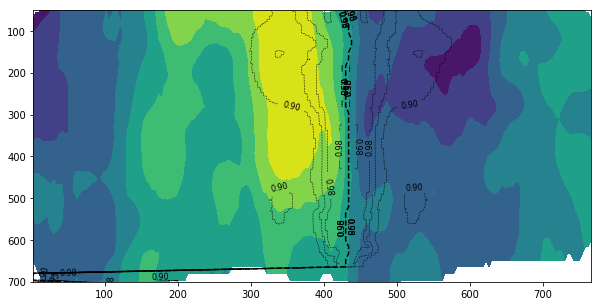

In [310]:
XX,ZZ = np.meshgrid(atd_reg/1000,depths)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(700,50)
ax.contourf(XX,ZZ,np.transpose(V_reg_filt))
ax.plot(Zeros/1000,depths,'k--',linewidth = 1.5)
levels = [0.9,0.95,0.98]
cont = ax.contour(faisceau/1000,ZZ2,Rvals_sim,linestyles='dashed',colors='k',linewidths=0.5,levels=levels)
ax.clabel(cont, fontsize=8, inline=1, fmt='%1.2f')
# ax.plot(faisceau[np.where(Pvals_sim>0.05)]/1000,ZZ2[np.where(Pvals_sim>0.05)],'k+',ms=2)
plt.show()

In [301]:
def R_lin(size,data,coords,zero):
    """
    Gives the r squared for the reg around center of size size
    """
    if np.isfinite(zero):
        subdata = data[(coords > zero - size)*(coords < zero + size)]
        subcoords = coords[(coords > zero - size)*(coords < zero + size)]
        fidx = np.where(np.isfinite(subdata))[0]
        if len(fidx) > 0:
            fdata = subdata[fidx]
            fcoords = subcoords[fidx]
            res = stats.linregress(fcoords,fdata)
            coeffs = np.array([res[0],res[1]])
            omega = np.abs(np.arctan(coeffs[0]))
            rs = res[2]**2
            p = res[3]
        else:
            rs = np.nan
            p = np.nan
            omega = np.nan
            coeffs = np.array([np.nan,np.nan])
    else:
        rs = np.nan
        p = np.nan
        omega = np.nan
        coeffs = np.array([np.nan,np.nan])
    return(rs,p,omega,coeffs)

def SBExtension(data,xcoords,deltat,sizemax = 200e3):
    """
    data is 1D
    coords is coords
    """
    Ss = np.arange(1e3,sizemax+1e3,1e3)
    lgth = len(Ss)
    Rs = []
    Ps = []
    Os = []
    Cs = []
    
    if np.sum(np.isfinite(data)) == 0:
        Rs = np.full(lgth,np.nan)
        Ps = np.full(lgth,np.nan)
        Os = np.full(lgth,np.nan)
        Cs = np.full(lgth,np.nan)
        zero = np.nan
    else:
        vmint = np.nancumsum(data)*deltat
        ymax = np.nanmax(vmint)
        vc_idx = np.where(vmint == ymax)[0]
        zero = xcoords[vc_idx]
        if len(zero) == 0:
            zero = np.nan
        elif len(zero) > 0:
            zero = zero[0]
        for size in Ss:
            r,p,o,coeffs = R_lin(size,data,xcoords,zero)
            Os.append(o)
            Rs.append(r)
            Ps.append(p)
            Cs.append(coeffs)
    Ss = np.array(Ss)
    Rs = np.array(Rs)
    Ps = np.array(Ps)
    Os = np.array(Os)
    Cs = np.array(Cs)
    return(Ss,Rs,Ps,Os,Cs,zero)
    
